# Sandbox

## Basic chatbot

Reference: [Part 1: Build a Basic Chatbot](https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-1-build-a-basic-chatbot)

In [29]:
%pip install -q langchain-openai langgraph grandalf

Note: you may need to restart the kernel to use updated packages.


In [14]:
import llm_config
from typing import Annotated, Any
from typing_extensions import TypedDict

from langchain_openai import AzureChatOpenAI

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [15]:
llm = AzureChatOpenAI(
    name="gpt-4o",
    model=llm_config.azure_model,
    azure_deployment=llm_config.azure_deploy,
    azure_endpoint=llm_config.api_base,
    api_version=llm_config.api_version,
    api_key=llm_config.api_key,
    temperature=0,
    timeout=None,
    max_retries=2,
)

Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.

In [16]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [17]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [18]:
# Next, add an entry point. This tells our graph where to start its work each
# time we run it.
graph_builder.add_edge(START, "chatbot")

In [19]:
# Similarly, set a finish point. This instructs the graph "any time this node is
# run, you can exit."
graph_builder.add_edge("chatbot", END)

In [20]:
# Finally, we'll want to be able to run our graph. To do so, call "compile()" on
# the graph builder.
# This creates a "CompiledGraph" we can use invoke on our state.
graph = graph_builder.compile()

In [21]:
try:
    print(graph.get_graph().draw_ascii())
except Exception as e:
    raise e

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
 +---------+   
 | chatbot |   
 +---------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


In [28]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    print(f"User: {user_input}")
    response = graph.stream({"messages": ("user", user_input)})
    for event in response:
        print("event")
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: How to open a can of beer.
event
Assistant: Opening a can of beer is a straightforward process, but it's important to do it carefully to avoid spills or injury. Here are the steps:

1. **Hold the Can Steady**: Place the can on a flat surface or hold it firmly in your hand. Make sure the can is upright and stable.

2. **Locate the Tab**: On the top of the can, you'll see a pull tab. This is the mechanism you'll use to open the can.

3. **Lift the Tab**: Use your thumb or a finger to lift the tab upwards. You may need to use a bit of force to get it started.

4. **Pull the Tab Back**: Once the tab is lifted, pull it back towards you. This will puncture the can's seal and create an opening.

5. **Listen for the Hiss**: As you pull the tab back, you should hear a hissing sound. This is the sound of the pressurized gas escaping, which is normal.

6. **Open Fully**: Continue pulling the tab back until it is fully open and lays flat against the top of the can.

7. **Enjoy Your Beer**: T

## Chatbot with Tools

Reference: [Part 2: Enhancing the Chatbot with Tools](https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-2-enhancing-the-chatbot-with-tools)

In [1]:
import json
import llm_config
import os

from typing import Annotated, Any, Literal
from typing_extensions import TypedDict

from langchain_openai import AzureChatOpenAI
from langchain_core.messages import ToolMessage, BaseMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_community.tools.tavily_search import TavilySearchResults

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = llm_config.tavily_api_key

tool = TavilySearchResults(max_results=2)
tools = [tool]
# tool.invoke("What's a 'node' in LangGraph?")

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [3]:
llm = AzureChatOpenAI(
    name="gpt-4o",
    model=llm_config.azure_model,
    azure_deployment=llm_config.azure_deploy,
    azure_endpoint=llm_config.api_base,
    api_version=llm_config.api_version,
    api_key=llm_config.api_key,
    temperature=0,
    timeout=None,
    max_retries=2,
)

llm_with_tools = llm.bind_tools(tools)

In [4]:
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [10]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # Get last message from inputs
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in inputs")
        outputs = []

        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    
tool_node = BasicToolNode(tools=tools)

In [11]:
def route_tools(state: State) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [12]:
graph_builder = StateGraph(State)

# nodes
graph_builder.add_node(node="chatbot", action=chatbot)
graph_builder.add_node(node="tools", action=tool_node)

# edges
graph_builder.add_edge(start_key=START, end_key="chatbot")
graph_builder.add_edge(start_key="chatbot", end_key=END)
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    path_map={
        "tools": "tools",
        "__end__": "__end__"
        }
    )
graph_builder.add_edge("tools", "chatbot")

# compile
graph = graph_builder.compile()

In [13]:
try:
    print(graph.get_graph().draw_ascii())
except Exception as e:
    raise e

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +---------+         
          | chatbot |         
          +---------+         
          .         .         
        ..           ..       
       .               .      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


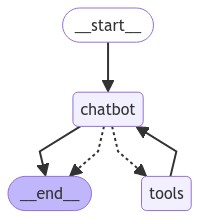

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    print(f"User: {user_input}")
    response = graph.stream(
        input={"messages": [("user", user_input)]},
        debug=False,
        )
    for event in response:
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User: Who won EURO 2024?
Assistant: 
Assistant: [{"url": "https://en.wikipedia.org/wiki/UEFA_Euro_2024_Final", "content": "The UEFA Euro 2024 final was a football match that determined the winners of UEFA Euro 2024.The match was the 17th final of the UEFA European Championship, a quadrennial tournament contested by the men's national teams of the member associations of UEFA to decide the champions of Europe. The match was held at the Olympiastadion in Berlin, Germany, on 14 July 2024, and was contested by Spain ..."}, {"url": "https://supersport.com/football/uefa-euro/news/42ab7223-039f-47b9-8d28-8f652498118d/spain-beat-england-to-win-euro-2024-final-with-late-oyarzabal-goal", "content": "Substitute Mikel Oyarzabal scored a dramatic late winner as Spain triumphed in Sunday's Euro 2024 final, beating England 2-1 to confirm their re-emergence as a force on the international stage and ..."}]
Assistant: Spain won the UEFA Euro 2024 final, defeating England 2-1 with a dramatic late goal by 

## Adding Memory to the Chatbot

Reference: [Part 3: Adding Memory to the Chatbot](https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-3-adding-memory-to-the-chatbot)

In [18]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# SQLite Memory
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = llm_config.tavily_api_key

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = AzureChatOpenAI(
    name="gpt-4o",
    model=llm_config.azure_model,
    azure_deployment=llm_config.azure_deploy,
    azure_endpoint=llm_config.api_base,
    api_version=llm_config.api_version,
    api_key=llm_config.api_key,
    temperature=0,
    timeout=None,
    max_retries=2,
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

### Base Graph

In [1]:
graph = graph_builder.compile(checkpointer=memory)

NameError: name 'graph_builder' is not defined

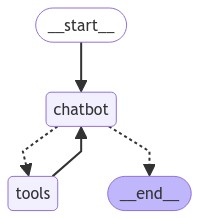

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Use a thread (for memory)
config = {"configurable": {"thread_id": "1"}}

In [ ]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    input={"messages": [("user", user_input)]},
    config=config,
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello, Will! How can I assist you today?


In [ ]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Got it, Will! I'll remember your name. How can I help you today?


### Human-in-the-loop

We interrupt the flow by adding `interrupt_before` parameter during compilation.

In [25]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"],
    )

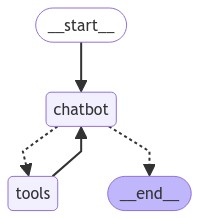

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_CI3l39cgdCycHYA4JiJUquwC)
 Call ID: call_CI3l39cgdCycHYA4JiJUquwC
  Args:
    query: LangGraph programming language


This is the place where the flow is interrupted (tool is being called).

In [28]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [29]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph programming language'},
  'id': 'call_CI3l39cgdCycHYA4JiJUquwC',
  'type': 'tool_call'}]

Resume the flow:

In [30]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph can be used to build a wide range of applications. Chatbots. LangGraph is ideal for developing sophisticated chatbots that can handle a wide array of user requests. By leveraging multiple LLM agents, these chatbots can process natural language queries, provide accurate responses, and seamlessly switch between different conversation ..."}, {"url": "https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141", "content": "Feb 14, 2024. 3. LangGraph is a powerful tool for building stateful, multi-actor applications with Large Language Models (LLMs). It extends the LangChain library, allowing you to coordinate ..."}]
================================== Ai Message ==================================

I found some useful resources on LangGraph for you:

1. **[LangGraph Tut

### Manually Updating the State

In [35]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# SQLite Memory
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = llm_config.tavily_api_key

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = AzureChatOpenAI(
    name="gpt-4o",
    model=llm_config.azure_model,
    azure_deployment=llm_config.azure_deploy,
    azure_endpoint=llm_config.api_base,
    api_version=llm_config.api_version,
    api_key=llm_config.api_key,
    temperature=0,
    timeout=None,
    max_retries=2,
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [36]:
# Memory + Interrupt
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"],
    )

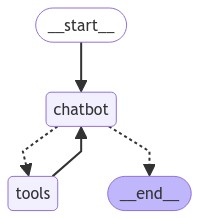

In [37]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [38]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bt1bDwC8pXNHe7d8CBBMSu7H)
 Call ID: call_bt1bDwC8pXNHe7d8CBBMSu7H
  Args:
    query: LangGraph programming language
  tavily_search_results_json (call_1jNl1QLcUPjYM3Yn1WdbZIHP)
 Call ID: call_1jNl1QLcUPjYM3Yn1WdbZIHP
  Args:
    query: LangGraph tutorials


We interrupt the flow just like the last time.
Now let's directly provide the correct response!

In [39]:
from langchain_core.messages import AIMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]
new_messages[-1].pretty_print()

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


We update the graph state with our "forged" Ai Message.

In [41]:
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
for message in graph.get_state(config).values["messages"][-2:]:
    message.pretty_print()



Last 2 messages;
================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


In [42]:
# Update the state once more with the message and make it look as it came from
# the "chatbot" node. By default, the `update_state()` sets the last node.
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef52606-d288-65fa-8004-3cafc5fb8506'}}

In [43]:
snapshot = graph.get_state(config)
for message in snapshot.values["messages"][-3:]:
    message.pretty_print()
print(snapshot.next)

================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

I'm an AI expert!
()


#### What if you want to overwrite existing messages?

In [44]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_aY0BcWQmXZlV5EDECbxWRmMM)
 Call ID: call_aY0BcWQmXZlV5EDECbxWRmMM
  Args:
    query: LangGraph programming language
  tavily_search_results_json (call_7ZxrqtUGrDBYN6ML2lScJh7S)
 Call ID: call_7ZxrqtUGrDBYN6ML2lScJh7S
  Args:
    query: LangGraph tutorials


In [45]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-970932d1-4c95-4ab5-926d-031c28b470da-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph programming language'}, 'id': 'call_aY0BcWQmXZlV5EDECbxWRmMM', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_aY0BcWQmXZlV5EDECbxWRmMM', 'type': 'tool_call'}
Message ID run-970932d1-4c95-4ab5-926d-031c28b470da-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_aY0BcWQmXZlV5EDECbxWRmMM',
  'type': 'tool_call'}]

Resuming ...

In [46]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph/blob/main/examples/agent_executor/human-in-the-loop.ipynb", "content": "Contribute to langchain-ai/langgraph development by creating an account on GitHub. ... Product Actions. Automate any workflow Packages. Host and manage packages Security. Find and fix vulnerabilities Codespaces. Instant dev environments GitHub Copilot ... human-in-the-loop.ipynb. Top. File metadata and controls. Preview. Code. Blame. 245 lines ..."}, {"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an..."}]
================================== Ai Message ==================================

Here are a couple of resources that might help you learn more about LangGraph and its human-in-

In [47]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

Yes, you're learning about LangGraph. Specifically, you asked for research on LangGraph and its human-in-the-loop workflow.


## Part 6: Customizing State

Reference: [Part 6: Customizing State](https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-6-customizing-state)

In [10]:
import llm_config
import os

from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

Next, define a schema to show the model to let it decide to request assistance.

In [11]:
from langchain_core.pydantic_v1 import BaseModel

class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to
    assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide
    the right guidance.
    """
    request: str


In [12]:
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = llm_config.tavily_api_key

tavily_search  = TavilySearchResults(max_results=2)
human_assistant = RequestAssistance

tools = [tavily_search, human_assistant]

llm = AzureChatOpenAI(
    name="gpt-4o",
    model=llm_config.azure_model,
    azure_deployment=llm_config.azure_deploy,
    azure_endpoint=llm_config.api_base,
    api_version=llm_config.api_version,
    api_key=llm_config.api_key,
    temperature=0,
    timeout=None,
    max_retries=2,
)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {
        "messages": [response],
        "ask_human": ask_human
        }


In [13]:
graph_builder = StateGraph(State)

graph_builder.add_node(node="chatbot", action=chatbot)
graph_builder.add_node(node="tools", action=ToolNode(tools=tools))

In [14]:
from langchain_core.messages import AIMessage, ToolMessage

def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }

graph_builder.add_node("human", human_node)

In [15]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)

In [16]:
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

In [17]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = SqliteSaver.from_conn_string(":memory:")

In [18]:
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

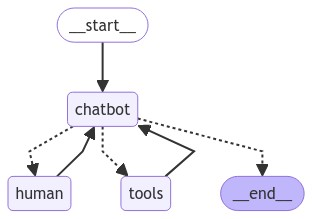

In [19]:

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_5pHdm5BhhSVIEB2NtmDXhL77)
 Call ID: call_5pHdm5BhhSVIEB2NtmDXhL77
  Args:
    request: I need some expert guidance for building an AI agent.


In [22]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [23]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef53d15-d1bb-6cbe-8002-065be59de857'}}

In [24]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='423ae592-0f15-475a-a0b2-da19c48ea2f8'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5pHdm5BhhSVIEB2NtmDXhL77', 'function': {'arguments': '{"request":"I need some expert guidance for building an AI agent."}', 'name': 'RequestAssistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 164, 'total_tokens': 189}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}

In [25]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend using LangGraph to build your AI agent, as it is more reliable and extensible than simple autonomous agents. If you have any specific questions or need further guidance, feel free to ask!


## Part 7: Time Travel

Reference: [Part 7: Time Travel](https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-7-time-travel)

In [26]:
import llm_config
import os

from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [27]:
from langchain_core.pydantic_v1 import BaseModel

class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to
    assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide
    the right guidance.
    """
    request: str


In [28]:
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = llm_config.tavily_api_key

tavily_search  = TavilySearchResults(max_results=2)
human_assistant = RequestAssistance

tools = [tavily_search, human_assistant]

llm = AzureChatOpenAI(
    name="gpt-4o",
    model=llm_config.azure_model,
    azure_deployment=llm_config.azure_deploy,
    azure_endpoint=llm_config.api_base,
    api_version=llm_config.api_version,
    api_key=llm_config.api_key,
    temperature=0,
    timeout=None,
    max_retries=2,
)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {
        "messages": [response],
        "ask_human": ask_human
        }


In [29]:
graph_builder = StateGraph(State)

graph_builder.add_node(node="chatbot", action=chatbot)
graph_builder.add_node(node="tools", action=ToolNode(tools=tools))

In [30]:
from langchain_core.messages import AIMessage, ToolMessage

def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }

graph_builder.add_node("human", human_node)

In [31]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)

In [32]:
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

In [33]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = SqliteSaver.from_conn_string(":memory:")

In [34]:
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

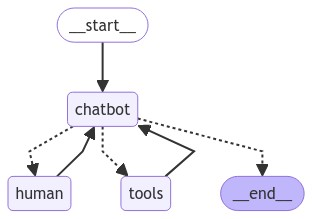

In [35]:

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [36]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_V8cv4ghUahA2tKXzByIyZUgS)
 Call ID: call_V8cv4ghUahA2tKXzByIyZUgS
  Args:
    query: LangGraph programming language
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://bhavikjikadara.medium.com/langgraph-a-comprehensive-guide-for-beginners-ef17d3dd5383", "content": "Some key features of LangGraph include: Graph-based data structures: Define complex data structures using graph theory concepts. Functional programming: Focus on immutability, recursion, and higher-order functions for concise code. Type-safe: Ensure type correctness through a statically typed language."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "conte

In [37]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph can leverage its strengths in handling complex data structures and functional programming. Here are some steps and tips to get you started:

### Steps to Build an Autonomous Agent with LangGraph:

1. **Define the Problem**:
   - Clearly outline what you want your autonomous agent to do. For example, it could be a chatbot, a recommendation system, or a data analysis tool.

2. **Set Up Your Development Environment**:
   - Install LangGraph and any necessary dependencies. Make sure your development environment is configured correctly.

3. **Design the Data Structures**:
   - Use LangGraph's graph-based data structures to model the information your agent will need to process. This cou

Now that we've had the agent take a couple steps, we can replay the full state history to see everything that occurred.

In [43]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("Config thread timestamp: ", state.config["configurable"]["thread_ts"])
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
Config thread timestamp:  1ef54870-b9bf-67e4-8006-e80e477e62e2
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
Config thread timestamp:  1ef54870-7c85-681a-8005-1a2c4daed70d
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
Config thread timestamp:  1ef54870-7c82-60b6-8004-75d6ad082f88
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
Config thread timestamp:  1ef5486f-9492-6576-8003-cfd174daaebf
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
Config thread timestamp:  1ef5486f-6491-625a-8002-56e42d530b78
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
Config thread timestamp:  1ef5486f-5228-633e-8001-b82bff61202f
---------------

In [39]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54870-b9bf-67e4-8006-e80e477e62e2'}}


Notice that the checkpoint's config (`to_replay.config`) contains a `thread_ts` 
timestamp.  
Providing this `thread_ts` value tells LangGraph's checkpointer to load the
state from that moment in time. Let's try it below:

In [46]:
# Next = tools invocation
contine_from_ts = "1ef5486f-5228-633e-8001-b82bff61202f"

continue_config = to_replay.config
continue_config["configurable"]["thread_ts"] = contine_from_ts

In [47]:
for event in graph.stream(None, continue_config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://bhavikjikadara.medium.com/langgraph-a-comprehensive-guide-for-beginners-ef17d3dd5383", "content": "Some key features of LangGraph include: Graph-based data structures: Define complex data structures using graph theory concepts. Functional programming: Focus on immutability, recursion, and higher-order functions for concise code. Type-safe: Ensure type correctness through a statically typed language."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph can be used to build a wide range of applications. Chatbots. LangGraph is ideal for developing sophisticated chatbots that can handle a wide array of user requests. By leveraging multiple LLM agents, these chatbots can process natural language queries, provide accurate responses, and seamlessly switch between different conversation ..."}]
==================================

Notice that the graph resumed execution from the **tools** node.
You can tell this is the case since the first value printed above is the 
response from our search engine tool.

Congratulations! You've now used time-travel checkpoint traversal in LangGraph.
Being able to rewind and explore alternative paths opens up a world of 
possibilities for debugging, experimentation, and interactive applications.